### Combining Feature Sets  
  
This notebook will be dedicated to further feature evaluation. The goal is to combine feature sets to get an idea of how each if affecting performance and then to reduce dimensions by averaging channels and selecting the most important features from whatever features remain.  
  
I will also be trying PCA with some of these feature sets (especially the wavelet feature sets), but this will be done in a separate notebook.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fastparquet, pyarrow
import mne
from mne.decoding import Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from utils import *

In [3]:
mne.set_log_level('WARNING')

In [4]:
df = pd.read_csv('by_patient.csv')

In [5]:
other_df = activity_df(df, 'Other', 'expert_consensus')
seizure_df = activity_df(df, 'Seizure', 'expert_consensus')
gpd_df = activity_df(df, 'GPD', 'expert_consensus')
lpd_df = activity_df(df, 'LPD', 'expert_consensus')
grda_df = activity_df(df, 'GRDA', 'expert_consensus')
lrda_df = activity_df(df, 'LRDA', 'expert_consensus')
activity_df_list = [other_df, seizure_df, gpd_df, lpd_df, grda_df, lrda_df]

In [6]:
activity_indexes = pd.read_csv('activity_indexes.csv')

In [7]:
index_lists = [activity_indexes[col] for col in activity_indexes.columns]

In [8]:
y = get_yvals(2000)['activity']

### Hjorth Altogether

In [10]:
X1 = pd.read_csv('time_mob_df.csv')
X2 = pd.read_csv('spectral_mob_df.csv')
X3 = pd.read_csv('time_comp_df.csv')
X4 = pd.read_csv('freq_comp_df.csv')
cols1, cols2, cols3, cols4 = X1.columns, X2.columns, X3.columns, X4.columns

In [24]:
#X1 = X1.drop(columns = ['Unnamed: 0'])
#X1.to_csv('time_mob_df.csv', index = None)

In [25]:
X1 = pd.read_csv('time_mob_df.csv')

In [27]:
#X2 = X2.drop(columns = ['Unnamed: 0'])
#X2.to_csv('spectral_mob_df.csv', index = None)
#X2 = pd.read_csv('spectral_mob_df.csv')

In [29]:
X1 = pd.read_csv('time_mob_df.csv')
X2 = pd.read_csv('spectral_mob_df.csv')
X3 = pd.read_csv('time_comp_df.csv')
X4 = pd.read_csv('freq_comp_df.csv')
cols1, cols2, cols3, cols4 = X1.columns, X2.columns, X3.columns, X4.columns

scaler1 = StandardScaler()
X1 = scaler1.fit_transform(X1)
X1 = pd.DataFrame(X1, columns = cols1)

scaler2 = StandardScaler()
X2 = scaler2.fit_transform(X2)
X2 = pd.DataFrame(X2, columns = cols2)

scaler3 = StandardScaler()
X3 = scaler3.fit_transform(X3)
X3 = pd.DataFrame(X3, columns = cols3)

scaler4 = StandardScaler()
X4 = scaler4.fit_transform(X4)
X4 = pd.DataFrame(X4, columns = cols4)

X = pd.concat([X1, X2], axis = 1)
X = pd.concat([X, X3], axis = 1)
X = pd.concat([X, X4], axis = 1)
X.to_csv('horth_df.csv', index = None)

In [33]:
X = pd.read_csv('horth_df.csv')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

### Notes on Results  
  
The Hjorth feature set has 76 columns. For frequency band power, it was 95 because there were 5 frequency band powers and 19 EEG channels. Here, there are two complexity and two mobility numbers and 19 EEG channels. Lower dimensionality and much better results. This may be the feature type to prioritize going forward.

In [34]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Hjorth Altogether Training')
print(classification_report(y_train, training_yhat))
print('Hjorth Altogether Testing')
print(classification_report(y_test, testing_yhat))
hjorth_acc = accuracy_score(y_test, testing_yhat)
hjorth_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
hjorth_f1 = f1_score(y_test, testing_yhat, average = None)
hjorth_prec = precision_score(y_test, testing_yhat, average = None)
hjorth_rec = recall_score(y_test, testing_yhat, average = None)

Hjorth Altogether Training
              precision    recall  f1-score   support

         GPD       0.77      0.92      0.84      1794
        GRDA       0.82      0.83      0.83      1819
         LPD       0.77      0.87      0.82      1800
        LRDA       0.83      0.87      0.85      1795
       Other       0.80      0.59      0.68      1808
     Seizure       0.80      0.72      0.75      1784

    accuracy                           0.80     10800
   macro avg       0.80      0.80      0.79     10800
weighted avg       0.80      0.80      0.79     10800

Hjorth Altogether Testing
              precision    recall  f1-score   support

         GPD       0.71      0.85      0.77       206
        GRDA       0.63      0.72      0.67       181
         LPD       0.64      0.71      0.67       200
        LRDA       0.74      0.77      0.76       205
       Other       0.57      0.38      0.46       192
     Seizure       0.70      0.59      0.64       216

    accuracy            

### Hjorth + Band Power Features

In [76]:
X1 = pd.read_csv('band_pow_df.csv')
X2 = pd.read_csv('time_mob_df.csv')
X3 = pd.read_csv('spectral_mob_df.csv')
X4 = pd.read_csv('time_comp_df.csv')
X5 = pd.read_csv('freq_comp_df.csv')

xlist = [X1, X2, X3, X4, X5]

full_set = pd.DataFrame()

for x in xlist:
    cols = x.columns
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns = cols)
    full_set = pd.concat([full_set, x], axis = 1)

In [77]:
X = full_set.copy()

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Hjorth Altogether Training')
print(classification_report(y_train, training_yhat))
print('Hjorth Altogether Testing')
print(classification_report(y_test, testing_yhat))
hjorth_acc = accuracy_score(y_test, testing_yhat)
hjorth_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
hjorth_f1 = f1_score(y_test, testing_yhat, average = None)
hjorth_prec = precision_score(y_test, testing_yhat, average = None)
hjorth_rec = recall_score(y_test, testing_yhat, average = None)

Hjorth Altogether Training
              precision    recall  f1-score   support

         GPD       0.82      0.94      0.88      1794
        GRDA       0.81      0.88      0.84      1819
         LPD       0.77      0.90      0.83      1800
        LRDA       0.85      0.90      0.87      1795
       Other       0.81      0.62      0.70      1808
     Seizure       0.90      0.70      0.79      1784

    accuracy                           0.82     10800
   macro avg       0.83      0.82      0.82     10800
weighted avg       0.83      0.82      0.82     10800

Hjorth Altogether Testing
              precision    recall  f1-score   support

         GPD       0.78      0.89      0.83       206
        GRDA       0.66      0.76      0.70       181
         LPD       0.67      0.81      0.73       200
        LRDA       0.77      0.82      0.80       205
       Other       0.60      0.47      0.53       192
     Seizure       0.84      0.57      0.68       216

    accuracy            

In [79]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 40)
X_pca = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.1, random_state = 42)

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Hjorth Altogether Training')
print(classification_report(y_train, training_yhat))
print('Hjorth Altogether Testing')
print(classification_report(y_test, testing_yhat))
hjorth_acc = accuracy_score(y_test, testing_yhat)
hjorth_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
hjorth_f1 = f1_score(y_test, testing_yhat, average = None)
hjorth_prec = precision_score(y_test, testing_yhat, average = None)
hjorth_rec = recall_score(y_test, testing_yhat, average = None)

Hjorth Altogether Training
              precision    recall  f1-score   support

         GPD       0.86      0.97      0.91      1794
        GRDA       0.85      0.92      0.89      1819
         LPD       0.84      0.93      0.88      1800
        LRDA       0.91      0.94      0.93      1795
       Other       0.91      0.71      0.80      1808
     Seizure       0.93      0.81      0.87      1784

    accuracy                           0.88     10800
   macro avg       0.88      0.88      0.88     10800
weighted avg       0.88      0.88      0.88     10800

Hjorth Altogether Testing
              precision    recall  f1-score   support

         GPD       0.79      0.91      0.84       206
        GRDA       0.69      0.84      0.76       181
         LPD       0.72      0.83      0.77       200
        LRDA       0.82      0.82      0.82       205
       Other       0.67      0.45      0.54       192
     Seizure       0.81      0.66      0.73       216

    accuracy            

### KMeans

In [14]:
from sklearn.cluster import KMeans

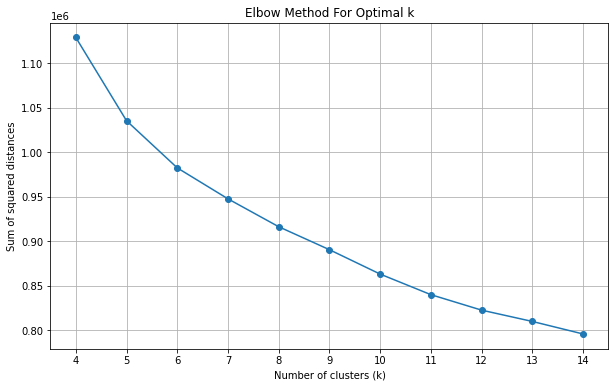

In [26]:
k_range = range(4, 15)
inertias = []
for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 'auto')
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.xticks(k_range)
plt.grid(True)
plt.show()

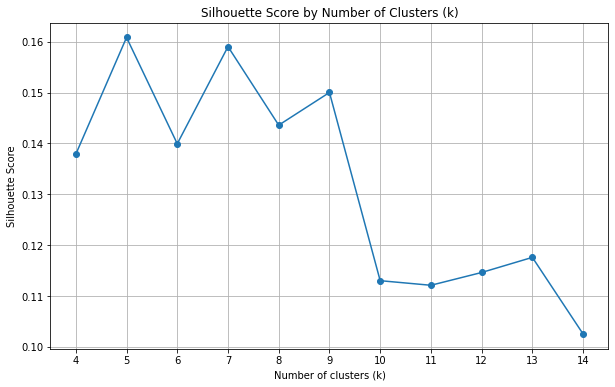

In [29]:
from sklearn.metrics import silhouette_score
k_range = range(4, 15)
scores = []
for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 'auto')
    scores.append(silhouette_score(X_pca, kmeans.fit_predict(X_pca)))

plt.figure(figsize=(10, 6))
plt.plot(k_range, scores, marker='o')
plt.title('Silhouette Score by Number of Clusters (k)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [30]:
scores

[0.13787983579396398,
 0.16082831648442053,
 0.1399348115256301,
 0.1590239990975515,
 0.1435920389076009,
 0.15001255982780787,
 0.11301809508129698,
 0.11211456842969976,
 0.11462736914578064,
 0.11759970207746236,
 0.10254160801905232]

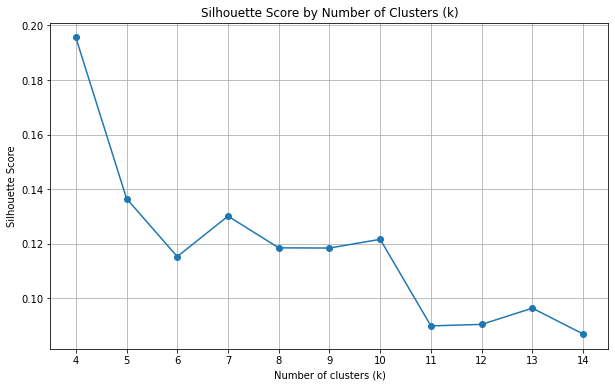

In [32]:
k_range = range(4, 15)
scores = []
for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 'auto')
    scores.append(silhouette_score(X_pca, kmeans.fit_predict(X_pca)))
    
plt.figure(figsize=(10, 6))
plt.plot(k_range, scores, marker='o')
plt.title('Silhouette Score by Number of Clusters (k)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [33]:
scores

[0.19558812937268552,
 0.13656806101618055,
 0.11529478256174776,
 0.130133513804376,
 0.11851204704481215,
 0.11843691258955791,
 0.12163359861079091,
 0.0899155496398803,
 0.09046571333851819,
 0.0964032054225796,
 0.08695186519008302]

### KMeans with Different Feature Sets

In [100]:
X1 = pd.read_csv('time_comp_df.csv')
X2 = pd.read_csv('time_mob_df.csv')
X3 = pd.read_csv('spectral_mob_df.csv')
X4 = pd.read_csv('freq_comp_df.csv')
X5 = pd.read_csv('band_pow_df.csv')

### Hjorth Time-Domain

In [50]:
hjorth_time = pd.DataFrame()
xlist_time = [X1, X2]
for x in xlist_time:
    cols = x.columns
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns = cols)
    hjorth_time = pd.concat([hjorth_time, x], axis = 1)

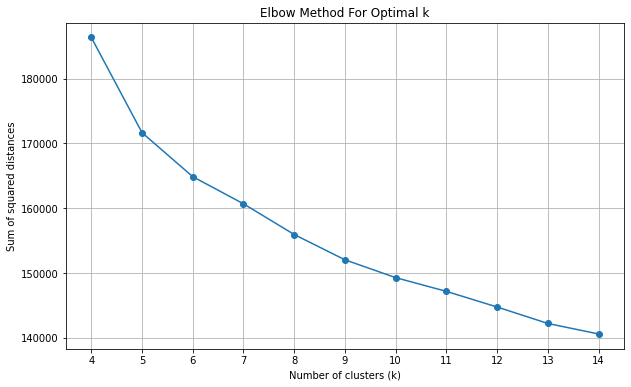

In [52]:
k_range = range(4, 15)
inertias = []
for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 'auto')
    kmeans.fit(hjorth_time)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.xticks(k_range)
plt.grid(True)
plt.show()

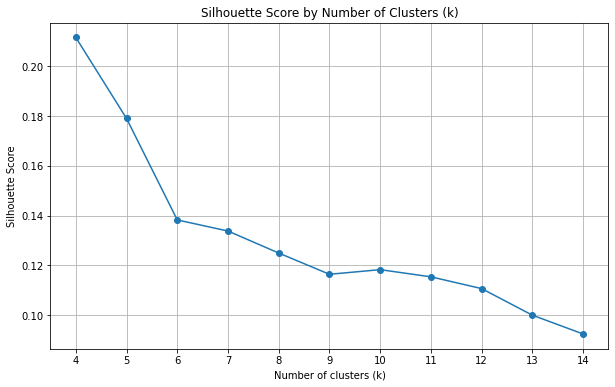

In [54]:
k_range = range(4, 15)
scores = []
for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 'auto')
    scores.append(silhouette_score(hjorth_time, kmeans.fit_predict(hjorth_time)))
    
plt.figure(figsize=(10, 6))
plt.plot(k_range, scores, marker='o')
plt.title('Silhouette Score by Number of Clusters (k)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [55]:
scores

[0.2115448995940778,
 0.17902144766224865,
 0.13828776714176916,
 0.13382304415942642,
 0.12499243367965977,
 0.11646310331261718,
 0.11831947886488083,
 0.11544177688951153,
 0.1107143938943452,
 0.10004188717829474,
 0.09249684364610304]

### Hjorth Frequency-Domain

In [56]:
hjorth_frequency = pd.DataFrame()
xlist_frequency = [X3, X4]
for x in xlist_frequency:
    cols = x.columns
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns = cols)
    hjorth_frequency = pd.concat([hjorth_frequency, x], axis = 1)

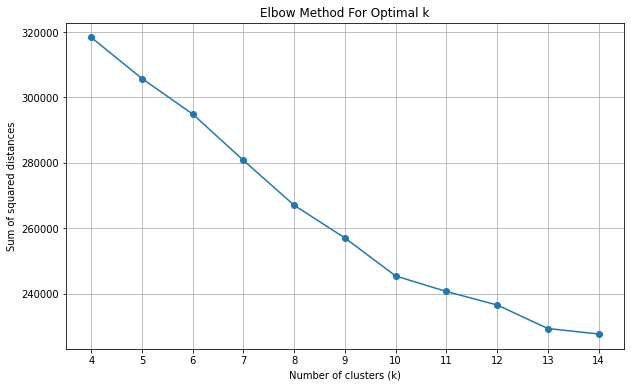

In [57]:
k_range = range(4, 15)
inertias = []
for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 'auto')
    kmeans.fit(hjorth_frequency)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.xticks(k_range)
plt.grid(True)
plt.show()

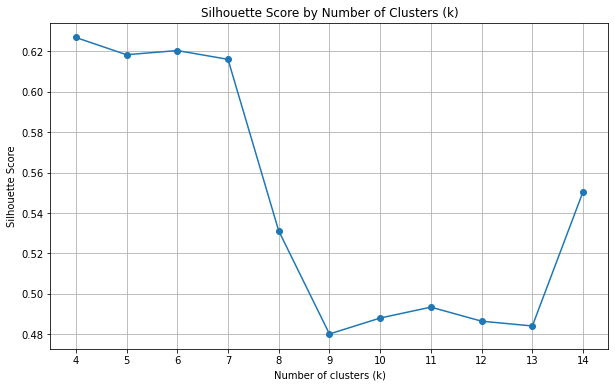

In [58]:
k_range = range(4, 15)
scores = []
for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 'auto')
    scores.append(silhouette_score(hjorth_frequency, kmeans.fit_predict(hjorth_frequency)))
    
plt.figure(figsize=(10, 6))
plt.plot(k_range, scores, marker='o')
plt.title('Silhouette Score by Number of Clusters (k)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [59]:
scores

[0.6268418101646945,
 0.6182925646911079,
 0.6203739714721013,
 0.6160191606448444,
 0.531142005864282,
 0.48013460277659076,
 0.48802528010775675,
 0.4934133327104972,
 0.4864575057318322,
 0.4840981335541205,
 0.5505783765892142]

### Band Power Only

In [109]:
cols = X5.columns
scaler = StandardScaler()
X5 = scaler.fit_transform(X5)
X5 = pd.DataFrame(X5, columns = cols)

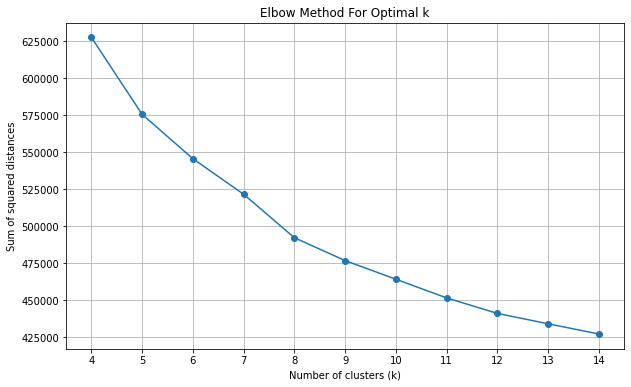

In [62]:
k_range = range(4, 15)
inertias = []
for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 'auto')
    kmeans.fit(X5)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.xticks(k_range)
plt.grid(True)
plt.show()

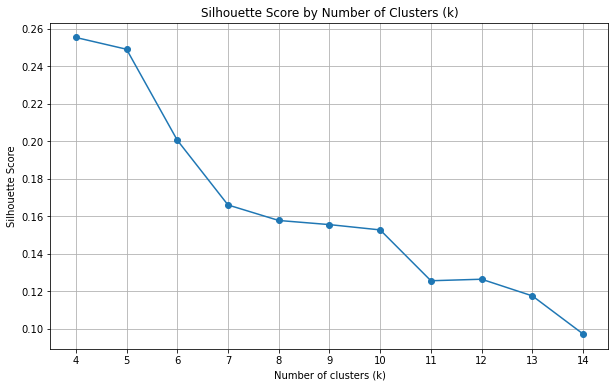

In [63]:
k_range = range(4, 15)
scores = []
for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 'auto')
    scores.append(silhouette_score(X5, kmeans.fit_predict(X5)))
    
plt.figure(figsize=(10, 6))
plt.plot(k_range, scores, marker='o')
plt.title('Silhouette Score by Number of Clusters (k)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [64]:
scores

[0.25539408439797623,
 0.24910941509087028,
 0.2006072631134807,
 0.16604875377435518,
 0.15777751046732816,
 0.15556544554684418,
 0.1527371835774692,
 0.12562084808820406,
 0.12643228707088724,
 0.11753788957433876,
 0.097229185694734]

In [65]:
pca = PCA(n_components = 50)
band_pca = pca.fit_transform(X5)
band_evr = pca.explained_variance_ratio_

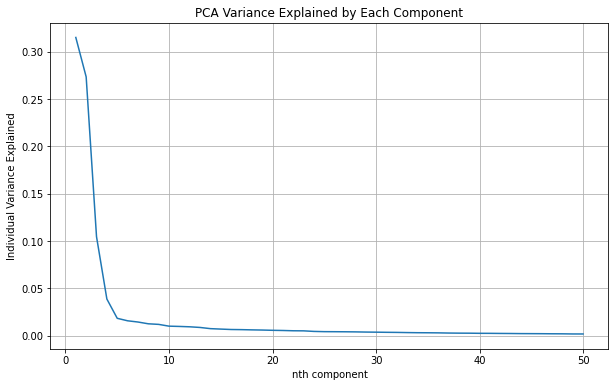

In [66]:
n_range = range(1, 51)
plt.figure(figsize = (10, 6))
plt.plot(n_range, band_evr)
plt.title('PCA Variance Explained by Each Component')
plt.xlabel('nth component')
plt.ylabel('Individual Variance Explained')
plt.grid(True)
plt.show()

In [67]:
rsum = 0
by_component = []
for r in band_evr:
    rsum += r
    by_component.append(rsum)

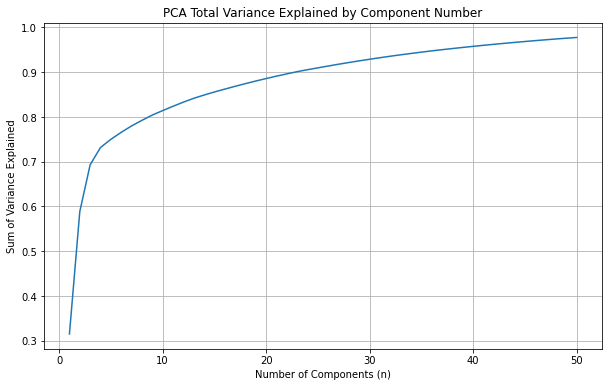

In [70]:
n_range = range(1, 51)
plt.figure(figsize = (10, 6))
plt.plot(n_range, by_component)
plt.title('PCA Total Variance Explained by Component Number')
plt.xlabel('Number of Components (n)')
plt.ylabel('Sum of Variance Explained')
plt.grid(True)
plt.show()

In [71]:
pca = PCA(n_components = 10)
band_pca = pca.fit_transform(X5)
band_evr_total = pca.explained_variance_ratio_.sum()

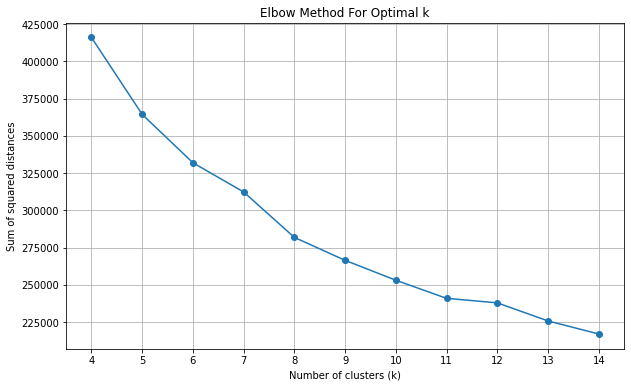

In [73]:
k_range = range(4, 15)
inertias = []
for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 'auto')
    kmeans.fit(band_pca)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.xticks(k_range)
plt.grid(True)
plt.show()

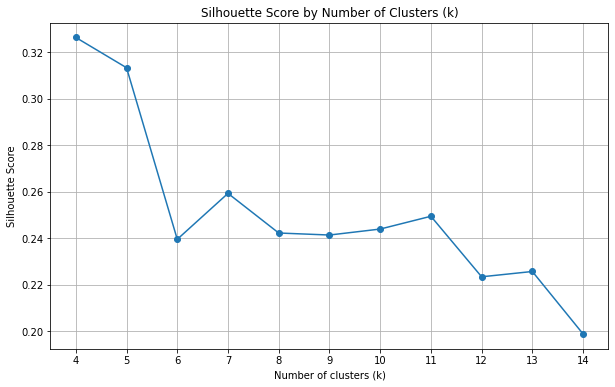

In [74]:
k_range = range(4, 15)
scores = []
for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 'auto')
    scores.append(silhouette_score(band_pca, kmeans.fit_predict(band_pca)))
    
plt.figure(figsize=(10, 6))
plt.plot(k_range, scores, marker='o')
plt.title('Silhouette Score by Number of Clusters (k)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [75]:
scores

[0.32638230468873153,
 0.31334977908315476,
 0.23949619242913983,
 0.25927051230956955,
 0.24220634617969797,
 0.24133658749764242,
 0.24390956025613028,
 0.24941537503465808,
 0.22335760715754538,
 0.22564189864533296,
 0.19874343070211406]

### Initial Results with Cluster Assignments  
  
**No Cluster Assignments as Baseline**

In [90]:
pca = PCA(n_components = 40)
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca, columns = ['component_{}'.format(i + 1) for i in range(40)])

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.1, random_state = 42)

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('PCA Set Scaled Training')
print(classification_report(y_train, training_yhat))
print('PCA Set Scaled Testing')
print(classification_report(y_test, testing_yhat))

PCA Set Scaled Training
              precision    recall  f1-score   support

         GPD       0.86      0.97      0.91      1794
        GRDA       0.85      0.92      0.89      1819
         LPD       0.84      0.93      0.88      1800
        LRDA       0.91      0.94      0.93      1795
       Other       0.91      0.71      0.80      1808
     Seizure       0.93      0.81      0.87      1784

    accuracy                           0.88     10800
   macro avg       0.89      0.88      0.88     10800
weighted avg       0.89      0.88      0.88     10800

PCA Set Scaled Testing
              precision    recall  f1-score   support

         GPD       0.79      0.92      0.85       206
        GRDA       0.70      0.85      0.77       181
         LPD       0.73      0.82      0.77       200
        LRDA       0.80      0.82      0.81       205
       Other       0.65      0.43      0.52       192
     Seizure       0.81      0.66      0.73       216

    accuracy                  

**Clustering with Hjorth Frequency Set**

In [93]:
k_range = range(4, 15)
train_accs, test_accs = [], []
for k in k_range:
    pca = PCA(n_components = 40)
    X_pca = pca.fit_transform(X)
    X_pca = pd.DataFrame(X_pca, columns = ['component_{}'.format(i + 1) for i in range(40)])

    kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 'auto')
    X_pca['cluster'] = kmeans.fit_predict(hjorth_frequency)

    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.1, random_state = 42)

    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train, y_train)
    training_yhat = knn.predict(X_train)
    testing_yhat = knn.predict(X_test)
    train_accs.append(accuracy_score(y_train, training_yhat))
    test_accs.append(accuracy_score(y_test, testing_yhat))

In [95]:
hfreq_clustering = pd.DataFrame([train_accs, test_accs], index = ['Training', 'Testing'],
                                columns = ['{} Clusters'.format(k) for k in k_range]).transpose()
hfreq_clustering

,Training,Testing
4 Clusters,0.880648,0.754167
5 Clusters,0.879630,0.748333
6 Clusters,0.880648,0.756667
7 Clusters,0.879722,0.746667
8 Clusters,0.875093,0.724167
9 Clusters,0.875741,0.734167
10 Clusters,0.875463,0.729167
11 Clusters,0.875741,0.738333
12 Clusters,0.874444,0.732500
13 Clusters,0.875926,0.730833


**Clustering with Band Power PCA Set**

In [110]:
pca = PCA(n_components = 10)
X5_pca = pca.fit_transform(X5)
X5_pca = pd.DataFrame(X5_pca, columns = ['component_{}'.format(i + 1) for i in range(10)])

In [116]:
train_accs, test_accs = [], []
for k in k_range:
    pca = PCA(n_components = 40)
    X_pca = pca.fit_transform(X)
    X_pca = pd.DataFrame(X_pca, columns = ['component_{}'.format(i + 1) for i in range(40)])

    kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 'auto')
    X_pca['cluster'] = kmeans.fit_predict(X5_pca)

    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.1, random_state = 42)

    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train, y_train)
    training_yhat = knn.predict(X_train)
    testing_yhat = knn.predict(X_test)
    train_accs.append(accuracy_score(y_train, training_yhat))
    test_accs.append(accuracy_score(y_test, testing_yhat))

In [117]:
bandpca_clustering = pd.DataFrame([train_accs, test_accs], index = ['Training', 'Testing'],
                                columns = ['{} Clusters'.format(k) for k in k_range]).transpose()
bandpca_clustering

,Training,Testing
4 Clusters,0.879630,0.750833
5 Clusters,0.877037,0.755833
6 Clusters,0.877778,0.744167
7 Clusters,0.877685,0.751667
8 Clusters,0.876759,0.744167
9 Clusters,0.875926,0.749167
10 Clusters,0.872500,0.738333
11 Clusters,0.873796,0.734167
12 Clusters,0.868333,0.730000
13 Clusters,0.869815,0.734167


**Clustering with Band Power Set (No PCA)**

In [118]:
train_accs, test_accs = [], []
for k in k_range:
    pca = PCA(n_components = 40)
    X_pca = pca.fit_transform(X)
    X_pca = pd.DataFrame(X_pca, columns = ['component_{}'.format(i + 1) for i in range(40)])

    kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 'auto')
    X_pca['cluster'] = kmeans.fit_predict(X5)

    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.1, random_state = 42)

    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train, y_train)
    training_yhat = knn.predict(X_train)
    testing_yhat = knn.predict(X_test)
    train_accs.append(accuracy_score(y_train, training_yhat))
    test_accs.append(accuracy_score(y_test, testing_yhat))

In [119]:
band_clustering = pd.DataFrame([train_accs, test_accs], index = ['Training', 'Testing'],
                                columns = ['{} Clusters'.format(k) for k in k_range]).transpose()
band_clustering

,Training,Testing
4 Clusters,0.879722,0.752500
5 Clusters,0.877593,0.750833
6 Clusters,0.874907,0.748333
7 Clusters,0.873611,0.745000
8 Clusters,0.872130,0.731667
9 Clusters,0.874259,0.738333
10 Clusters,0.871574,0.735833
11 Clusters,0.875741,0.731667
12 Clusters,0.873241,0.726667
13 Clusters,0.870093,0.725833


### Some Discussion  
  
Adding a cluster assignment feature doesn't seem to move the needle. When it does move the needle, it moves it slightly in the negative direction. It's possible that a different set of features to cluster with or a different clustering algorithm would yield better meaningful and positive results. I'm going to at least try some different clustering algorithms, but that's all I have time for. I still think there should be an effective way to use cluster assignments as a feature and improve performance with the Other category specifically, but I haven't found the way to do that, yet.  
  
### DBSCAN

In [120]:
from sklearn.cluster import DBSCAN

In [122]:
X_pca = X_pca.drop(columns = 'cluster')

In [123]:
dbs = DBSCAN()
silhouette_score(X_pca, dbs.fit_predict(X_pca))

-0.3083338758432493

### BIRCH

In [124]:
from sklearn.cluster import Birch

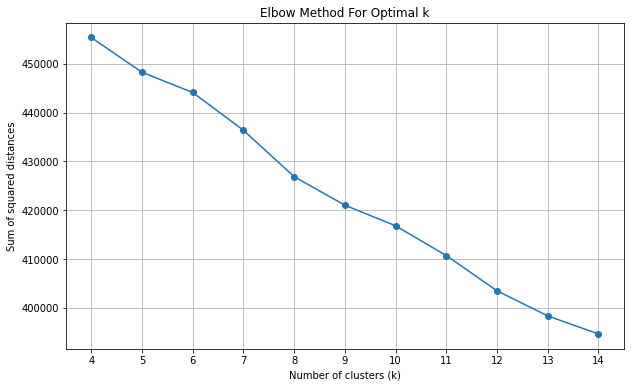

In [127]:
k_range = range(4, 15)
scores = []
for k in k_range:
    birch = Birch(n_clusters = k)
    scores.append(silhouette_score(X_pca, birch.fit_predict(X_pca)))

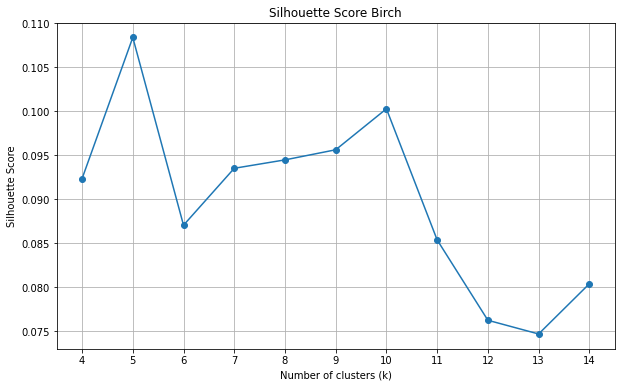

In [129]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, scores, marker='o')
plt.title('Silhouette Score Birch')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()

### Ward

In [130]:
from sklearn.cluster import AgglomerativeClustering

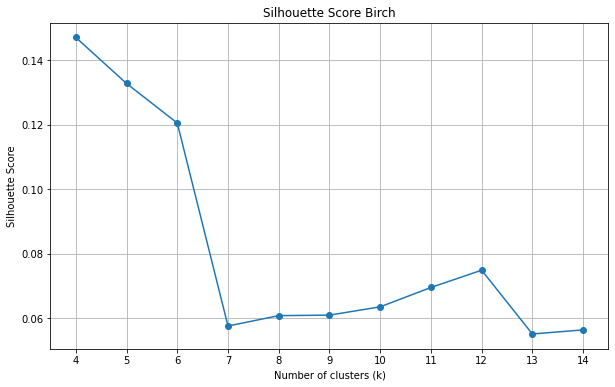

In [131]:
k_range = range(4, 15)
scores = []
for k in k_range:
    ward = AgglomerativeClustering(n_clusters = k)
    scores.append(silhouette_score(X_pca, ward.fit_predict(X_pca)))

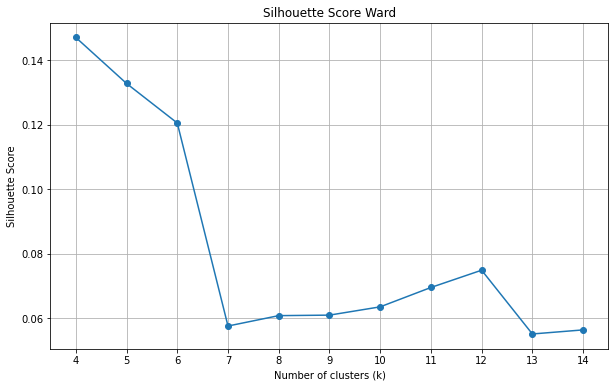

In [132]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, scores, marker='o')
plt.title('Silhouette Score Ward')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()